In [2]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import algorithms.areamanager
%matplotlib inline


# Categories analysis

In [4]:
df_categories=pd.read_json("../data/categories.json")

# dicionário alias title 2 way
dict_alias_title=dict()
for index, row in df_categories.iterrows():
    dict_alias_title[row['alias']]=row['title']
    dict_alias_title[row['title']]=row['alias']


category_tree= nx.DiGraph()
for index, row in df_categories.iterrows():
    if not row['parents']:
        category_tree.add_edge(row['alias'],'root') # root node if no parents
    else:
        for parent_label in row['parents']:
            category_tree.add_edge(row['alias'],parent_label)

undirected_category_tree=category_tree.to_undirected()
# dict alias depth
dict_alias_depth=dict()
for index, row in df_categories.iterrows():
    dict_alias_depth[row['alias']]=nx.shortest_path_length(category_tree,row['alias'],'root')
dict_alias_depth['root']=0
df_categories=None

In [5]:
print("Número de categorias sem filtragem:",len(category_tree))

Número de categorias sem filtragem: 1566


In [6]:
count_nodes_in_depth=[0,0,0,0,0]
for category in category_tree.nodes:
    if count_nodes_in_depth[dict_alias_depth[category]] is None:
        count_nodes_in_depth[dict_alias_depth[category]]
    else:
        count_nodes_in_depth[dict_alias_depth[category]]=count_nodes_in_depth[dict_alias_depth[category]]+1
count_nodes_in_depth

[1, 22, 997, 527, 19]

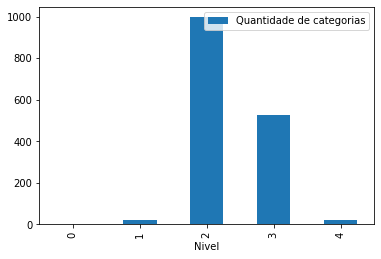

In [20]:
df=pd.DataFrame(count_nodes_in_depth,columns=['Quantidade de categorias'])
df.index.names=['Nivel']
df.plot(kind='bar')

In [23]:
df

,Quantidade de categorias
Nivel,
0,1
1,22
2,997
3,527
4,19


# Review and tip dataset 

In [114]:
columns=[('categoriaaa','users'),
         ('categoriaaa','pois'),
         ('categoriaaa','checkins'),
         ('categoriaaa','categories'),
         ('categoriaaa','subareas'),
         ('categoriaaa','pois/users'),
         ('categoriaaa','checkins/users'),
         ('categoriaaa','checkins/pois'),
         ('categoriaaa','pois/subareas'),
         ('user_diff_checkins','mean'),
         ('user_diff_checkins','std'),
         ('user_diff_checkins','25%'),
         ('user_diff_checkins','50%'),
         ('user_diff_checkins','75%'),
         ('user_checkins','mean'),
         ('user_checkins','std'),
         ('user_checkins','25%'),
         ('user_checkins','50%'),
         ('user_checkins','75%'),
         ('subareas_poi','count'),
         ('subareas_poi','mean'),
         ('subareas_poi','std'),
         ('subareas_poi','25%'),
         ('subareas_poi','50%'),
         ('subareas_poi','75%'),
         ('subareas_checkin','count'),
         ('subareas_checkin','mean'),
         ('subareas_checkin','std'),
         ('subareas_checkin','25%'),
         ('subareas_checkin','50%'),
         ('subareas_checkin','75%')]

df_city_info=pd.DataFrame(columns=pd.MultiIndex.from_tuples(columns))
df_city_info.index.name="city"


In [115]:
def string_to_array(string):
    if string == '':
        return list()
    return eval(string)

def cities_info_generator(city_name):
    df_city_checkin=pd.read_csv("../data/checkin/"+city_name+".csv",converters={'categories':string_to_array})
    df_city_checkin.head()
    df_city_poi=pd.read_csv("../data/poi/"+city_name+".csv",converters={'categories':string_to_array})
    df_city_poi.head()
    # number of users
    users=df_city_checkin['user_id'].nunique()
    # number of pois
    pois=df_city_poi['business_id'].count()
    # number of check-ins
    checkins=df_city_checkin['date'].count()
    # number of categories
    categories_in_city=set()
    df_city_checkin.apply(lambda checkin: categories_in_city.update(checkin['categories']),axis=1)
    categories=len(categories_in_city)

    subareas=df_city_poi['subarea_id'].nunique()
    pois_per_users=pois/users
    checkins_per_users=checkins/users
    checkins_per_pois=checkins/pois
    poi_per_subarea=pois/subareas

    # diff pois visited, mean of diff pois visited of users
    user_diff_checkins=df_city_checkin[['user_id','business_id','date']].groupby(['user_id','business_id']).count().groupby('user_id').count()['date'].describe()
    # number check-ins of a user, mean of users check-ins on pois
    user_checkins=df_city_checkin[['user_id','business_id','date']].groupby(['user_id','business_id']).count().groupby('user_id').sum()['date'].describe()

    # subareas poi
    subareas_poi=df_city_poi[['subarea_id','business_id']].groupby('subarea_id').count().describe()['business_id']
    subareas_checkin=df_city_checkin[['subarea_id','user_id']].groupby('subarea_id').count().describe()['user_id']
    df_city_poi[['subarea_id','business_id']].groupby('subarea_id').count().sort_values(by='business_id',ascending=False).reset_index(drop=True).reset_index().plot.scatter(
        x=0,y="business_id")

    df_city_checkin[['subarea_id','user_id']].groupby('subarea_id').count().sort_values(by='user_id',ascending=False).reset_index(drop=True).reset_index().plot.scatter(x=0,y="user_id")
    df_city_info.loc[city_name]= [users,pois,checkins,categories,subareas,
                                pois_per_users,checkins_per_users,checkins_per_pois,poi_per_subarea,
                                user_diff_checkins['mean'],
                                user_diff_checkins['std'],
                                user_diff_checkins['25%'],
                                user_diff_checkins['50%'],
                                user_diff_checkins['75%'],
                                user_checkins['mean'],user_checkins['std'],
                                user_checkins['25%'],user_checkins['50%'],
                                user_checkins['75%'],
                                subareas_poi['count'],
                                subareas_poi['mean'],
                                subareas_poi['std'],
                                subareas_poi['25%'],
                                subareas_poi['50%'],
                                subareas_poi['75%'],
                                subareas_checkin['count'],
                                subareas_checkin['mean'],
                                subareas_checkin['std'],
                                subareas_checkin['25%'],
                                subareas_checkin['50%'],
                                subareas_checkin['75%']]
    return df_city_info